# Learning Curves

### Preamble

In [1]:
SYS_PATH = 'C:/Users/mark/Documents/GitHub/honours/dev/package/'
SAVE_PATH = r"C:/Users/mark/Documents/GitHub/honours/submissions/thesis-original"
LOAD_PATH = r"C:/Users/mark/Documents/GitHub/honours/dev/package/analysis/output/temp/output.db"

In [2]:
#standard imports
import sys
import numpy as np
import pandas as pd
from datetime import date, timedelta
import math
from itertools import chain

#third party imports
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import rcParams
import matplotlib.ticker as tkr
import seaborn as sns
from sklearn import metrics

#local imports
sys.path.append(SYS_PATH)

In [3]:
%matplotlib inline

TINY_SIZE, SMALL_SIZE, MEDIUM_SIZE, BIGGER_SIZE  = 12, 16, 20, 30
plt.style.use(['seaborn-white', 'seaborn-paper'])
sns.set_palette("colorblind")
rcParams['font.family'] = 'serif' 
rcParams['font.serif'] = 'CMU Serif' 
rcParams['font.weight'] = 'bold'
rcParams['font.size'] = SMALL_SIZE #default font size
rcParams['axes.titlesize'] =SMALL_SIZE   # fontsize of the axes title
rcParams['axes.labelsize'] =MEDIUM_SIZE    # fontsize of the x and y labels
rcParams['xtick.labelsize'] =SMALL_SIZE    # fontsize of the tick labels
rcParams['ytick.labelsize'] =SMALL_SIZE   # fontsize of the tick labels
rcParams['legend.fontsize'] =SMALL_SIZE    # legend fontsize
rcParams['figure.titlesize'] =BIGGER_SIZE  # fontsize of the figure title
rcParams['figure.figsize'] = (8,3)
pd.set_option('precision',3)
outline_bars = dict(linewidth = 1.25, edgecolor = '.15')

In [4]:
def format_axis_ticks(f, axis="x", fmt="{:,}"):
    axes = [item for sublist in f.axes for item in sublist]
    for ax in axes:
        if axis == "x": ax.xaxis.set_major_formatter(tkr.FuncFormatter(lambda x, p: fmt.format(int(x))))
        elif axis =="y": ax.yaxis.set_major_formatter(tkr.FuncFormatter(lambda x, p: fmt.format(int(x))))
        else: raise ValueError

In [5]:
def get_feature_values(df, total="Y_Pred"):
    
    def listify(col):
        if type(col.ix[0]) not in [list, np.ndarray, np.array, pd.Series]: 
            return col.apply(lambda x: [x])
        else: return col
    
    def multip(row):
        for col in row.index:
            if col != "total" and type(row[col]) is list and len(row[col]) != row["total"][0]:
                row[col] = row[col] * row["total"][0]
        return row

    df["total"] = df[total].apply(len)
    df = df.apply(listify, axis=0)
    df = df.apply(multip, axis=1)
    df = df.drop("total",axis=1)
    df = df.apply(lambda x: list(chain.from_iterable(x)),axis=0)
    df = df.apply(pd.Series).T
    return df

In [6]:
def feature_function(df, func, group=None):
    df[["Y_Pred","Y_True"]] = df[["Y_Pred","Y_True"]].apply(lambda x: pd.to_numeric(x,errors="coerce"))
    if group: return df.groupby(group).apply(lambda x: func(x["Y_True"], x["Y_Pred"]))
    else: return func(df["Y_True"], df["Y_Pred"])

In [7]:
def get_results(build, stage):
    
    df = pd.read_pickle(r"C:\Users\mark\Documents\GitHub\honours\dev\package\analysis\output\autoVC\{}\{}\log_results.pkl".format(build, stage))
    df = df.reset_index()
    try: df["Time"] = pd.to_numeric(df["mean_fit_time"],errors="coerce")
    except: print("Error: Time")
    try: df["Imputer"] = df["param_imputer__strategy"].map({"most_frequent": "Mode", "median": "Median", "mean": "Mean"})
    except: print("Error: Imputer")
    try: df["Transformer"] = df["param_transformer__func"].astype(str).map({"None":"None","<ufunc 'sqrt'>":"SQRT","<ufunc 'log1p'>": "Log1P"})
    except: print("Error: Transformer")
    try: df["Scaler"] = df['param_scaler'].apply(lambda x: str(x).split("(")[0])
    except: print("Error: Scaler")
    try: 
        df["param_extractor__n_components_bin_20"] = df["param_extractor__n_components"] // 20
        df["Extractor"]=df['param_extractor__n_components_bin_20'].map({0 : "1-20", 1 : "21-40", 2: "41-60",3: "61-80", 4: "81-100"})
    except: print("Error: Extractor")
    try: 
        df["Classifier"] = df["Classifier"].apply(lambda x: str(x).split("(")[0])
        df["Classifier"]=df['Classifier'].map({"LogisticRegression": "Logistic Regression", "RandomForestClassifier":"Random Forest", "DecisionTreeClassifier": "Decision Tree", "GaussianNB": "Naive Bayes", "MLPClassifier": "Artificial Neural Network", "KNeighborsClassifier": "K-Nearest Neighbors", "CalibratedClassifierCV": "Support Vector Machine"})
    except: print("Error: Classifier")
    try:
        df["label_date"] = df["label_slice"]
        df["label_date_str"] = df["label_date"].astype(str)
        df["feature_date"] = df["feature_slice"]
        df["feature_date_str"] = df["feature_date"].astype(str)
        df["forecast_window"] =  df["label_date"] - df["feature_date"]
        df["forecast_window_years"] = df["forecast_window"].apply(lambda x: x.days // 30) / 12
    except: print("Error: Dates")
    try: df["dataset_type"] = df["dataset_type"].map({"train":"Training Score","test":"Test Score"})
    except: print("Error: Learning Curve")
    try: df["label_type"] = df["label_type"].apply(lambda x: x.replace("_", " "))
    except: print("Error: Target Outcome")
    try:
        df["outcome_chance"] = df["label_name"].apply(lambda x: pd.Series(x).value_counts(normalize=True)[1])
    except: print("Error: Outcome")
    df["Params_str"] = df["Params"].astype(str)
    return df

In [8]:
def plot_learning_curve(df, ax = None, group = None, target = None, multiple=False, legend=False):
    
    def concat_lists(series):
        return np.array(list(zip(*[element for list_ in [np.array(list(zip(*list_))) for list_ in series] for element in list_])))

    if not ax: ax = plt.gca()
    
    if group and target:
        test_scores = concat_lists(df.loc[df[group] == target]["Test_Scores"])
        train_scores = concat_lists(df.loc[df[group] == target]["Train_Scores"])
        train_sizes = df.loc[df[group] == target]["Train_Sizes"].sample(1).squeeze()
        ax.set_title("{}".format(target))
    else:
        test_scores = concat_lists(df["Test_Scores"])
        train_scores = concat_lists(df["Train_Scores"])
        train_sizes = df["Train_Sizes"].sample(1).squeeze()

    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores,axis=1)
    test_mean = np.mean(test_scores, axis=1)
    test_std = np.std(test_scores, axis=1)
            
    ax.plot(train_sizes, train_mean, 'o-', color="blue", label="Training")
    ax.plot(train_sizes, test_mean, 'o-', color="green", label="Cross-validation")
    
    handles, labels = ax.get_legend_handles_labels()

    ax.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.1, color="blue")
    ax.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, alpha=0.1, color="green")
    
    ax.set_ylim(ymin=0, ymax=1)
    ax.set_xticklabels(["{:,.0f}".format(xtick) for xtick in ax.get_xticks().tolist()])

    return (handles, labels)

In [9]:
def plot_learning_curves(df, group, x_label='Training Examples',y_label ='Score',figsize=None):
    targets = df[group].value_counts().index.tolist()
    if len(targets) == 3: rows, cols = 1, 3
    elif len(targets) == 7: rows, cols = 2, 4
    else:
        cols = math.ceil(math.sqrt(len(targets)))
        rows = math.ceil(len(targets) / cols)
    f, axes = plt.subplots(nrows=rows, ncols=cols, figsize=figsize, sharey=True)
    axes = [item for sublist in axes for item in sublist]
    if len(targets) == 1: axes = [axes]
    for i, target in enumerate(targets):
        leg = plot_learning_curve(df, axes[i], group=group, target=target, multiple=True)
        if i == 6: axes[i].legend(*leg)
    for x in range(len(targets), len(axes)): f.delaxes(axes[x])
    f.text(0.5, -0.04, x_label, ha='center',size=MEDIUM_SIZE)
    f.text(-0.04, 0.5, y_label, va='center', rotation='vertical',size=MEDIUM_SIZE)
    plt.tight_layout()
    return f

### Learning curves by forecast window (DONE)

In [33]:
reload = False

In [34]:
chart_id = "figures/evaluation/learning_curves_window"
pickle_path = "{}/{}.pkl".format(SAVE_PATH, chart_id)

In [35]:
try: 
    if reload: data = pd.read_pickle(pickle_path)
    else: raise IOError
except IOError: 
    data = get_results(25, "evaluate")
    data = data[["dataset_size", "PRC", "dataset_type","forecast_window_years"]]
    data.to_pickle(pickle_path)

Error: Time
Error: Imputer
Error: Transformer
Error: Scaler
Error: Extractor


In [36]:
x = "dataset_size"
y = "PRC"
hue = "dataset_type"
hue_order = ["Training Score", "Test Score"]
col = "forecast_window_years"
col_order = [2,3,4]

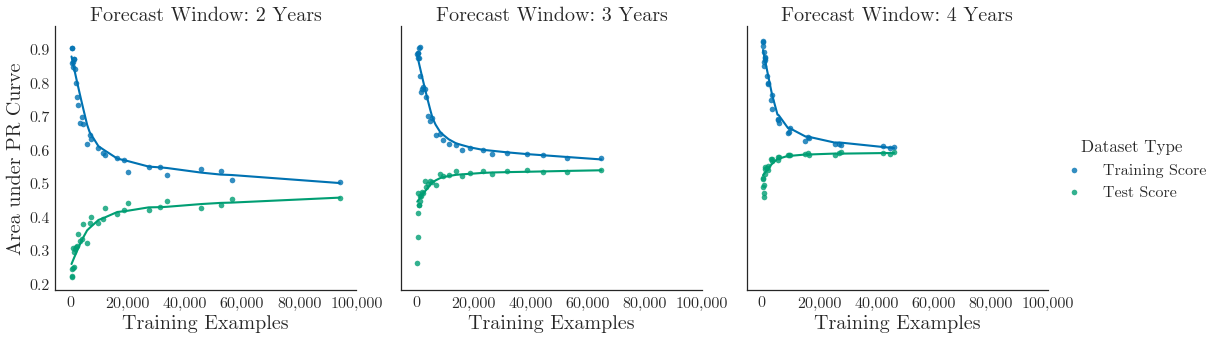

In [40]:
f = sns.lmplot(data = data, x=x, y=y, hue=hue, col=col, hue_order=hue_order,fit_reg =True, lowess  =True, legend=False)
f = f.set_axis_labels("Training Examples", "Area under PR Curve")
f = f.set_titles("Forecast Window: {col_name:.0f} Years")
format_axis_ticks(f, axis="x", fmt="{:,}")
plt.tight_layout()
f = f.add_legend(title="Dataset Type")

In [41]:
output_path =  "{}/{}.pdf".format(SAVE_PATH, chart_id)
f.savefig(output_path, bbox_inches="tight")

### Learning curves by target outcome (DONE)

In [42]:
reload = False

In [43]:
chart_id = "figures/evaluation/learning_curves_outcome_window"
pickle_path = "{}/{}.pkl".format(SAVE_PATH, chart_id)

In [44]:
try: 
    if reload: data = pd.read_pickle(pickle_path)
    else: raise IOError
except IOError: 
    data = get_results(16, "evaluate")
    data = data[["dataset_size", "PRC", "dataset_type","label_type","forecast_window_years"]]
    data.to_pickle(pickle_path)

Error: Time
Error: Imputer
Error: Transformer
Error: Scaler
Error: Extractor


In [45]:
x = "dataset_size"
y = "PRC"
hue = "dataset_type"
col = "label_type"
row= "forecast_window_years"

In [46]:
hue_order = ["Training Score", "Test Score"]
col_order = ["Extra Stage", "Extra Round", "Exit", "Acquisition", "IPO"]
x_label = "Training Examples"
y_label = "Area under PR Curve"
f_titles = "{col_name} x {row_name:.0f} Years"
leg_title = "Dataset Type"

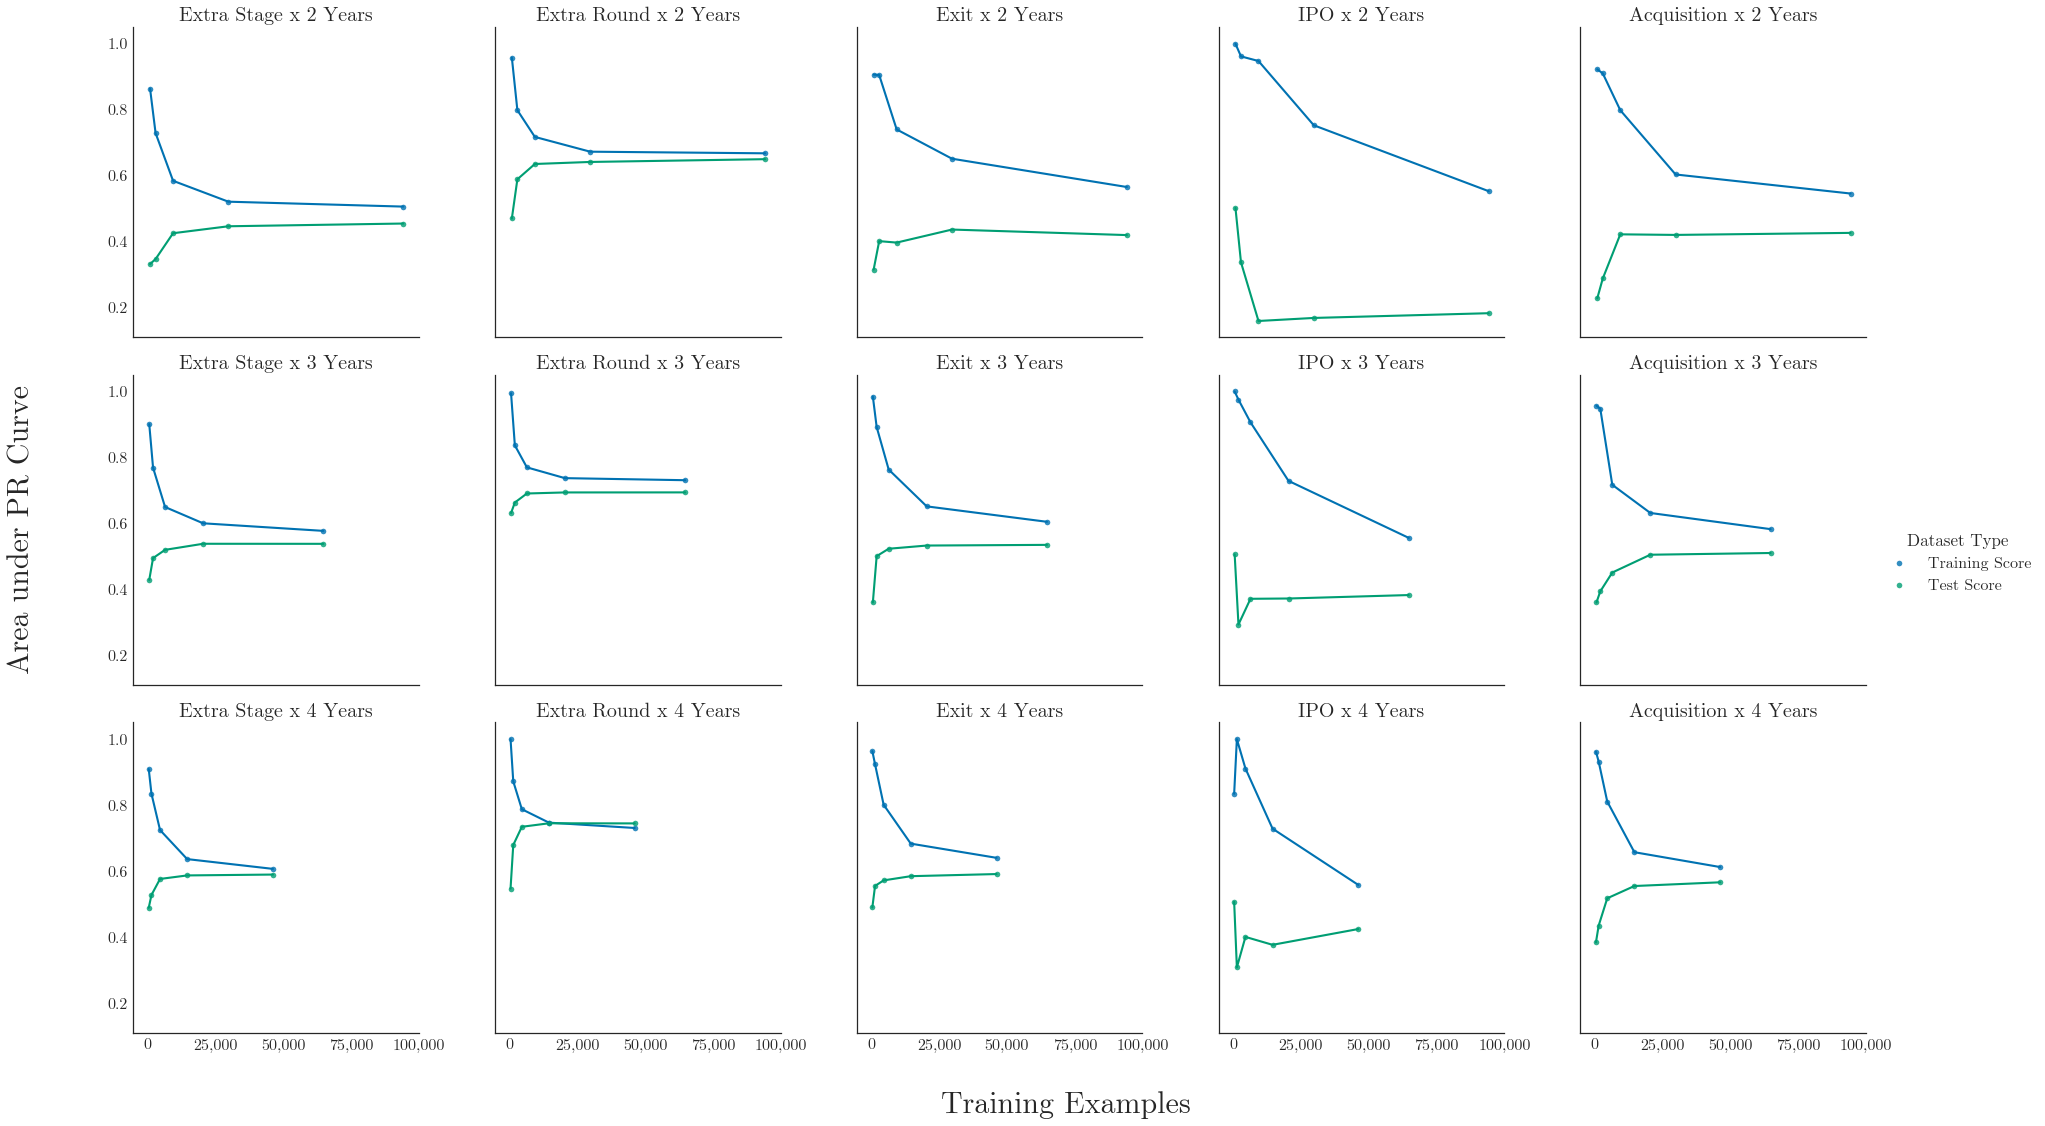

In [47]:
f = sns.lmplot(data = data, x=x, y=y, hue=hue, col=col, row=row, hue_order=hue_order, fit_reg =True, lowess  =True, legend=False)
f = f.set_axis_labels("", "")
f = f.set_titles(f_titles)
format_axis_ticks(f, axis="x", fmt="{:,}")
plt.tight_layout()
f.fig.text(0.5, -0.04, x_label, ha='center',size=BIGGER_SIZE)
f.fig.text(-0.04, 0.5, y_label, va='center', rotation='vertical',size=BIGGER_SIZE)
f = f.add_legend(title=leg_title)

In [48]:
output_path =  "{}/{}.pdf".format(SAVE_PATH, chart_id)
f.savefig(output_path, bbox_inches="tight")

### Learning curves by classification algorithms (DONE)

In [51]:
reload = True

In [52]:
chart_id = "figures/design/learning_curves_classifier"
pickle_path = "{}/{}.pkl".format(SAVE_PATH, chart_id)

In [53]:
try: 
    if reload: data = pd.read_pickle(pickle_path)
    else: raise IOError
except IOError: 
    data = get_results(16, "create")
    data = data[["Classifier","Test_Scores","Train_Scores","Train_Sizes"]]
    data.to_pickle(pickle_path)

Error: Learning Curve
Error: Target Outcome


In [60]:
x_label = "Training Examples"
y_label = "Area under Precision-Recall Curve"

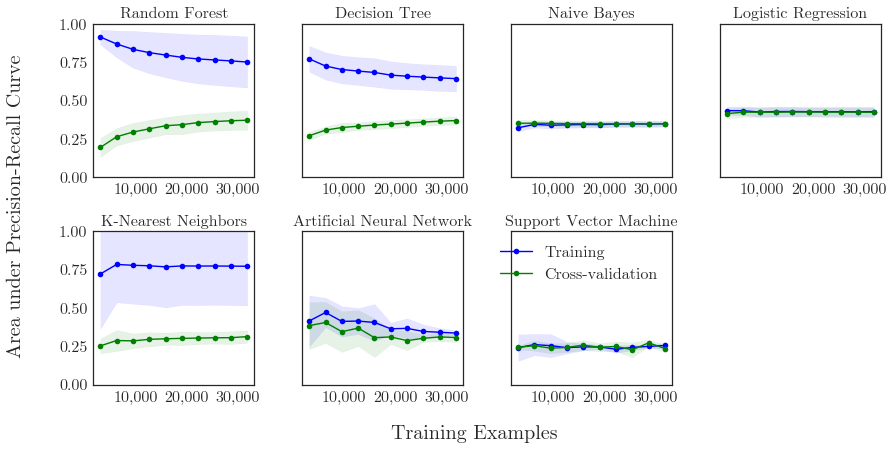

In [139]:
with plt.rc_context({'figure.figsize': (12,6)}):
    f = plot_learning_curves(data, group="Classifier", x_label=x_label, y_label=y_label)

In [140]:
output_path =  "{}/{}.pdf".format(SAVE_PATH, chart_id)
f.savefig(output_path, bbox_inches="tight")